# Convex hull as diagnostic tool in single-molecule localization microscopy
# Localization precision determination via convex hull

In [1]:
import numpy as np
import locan as lc
import colorcet as cc
import boost_histogram as bh
from sklearn.cluster import DBSCAN

import matplotlib.pyplot as plt
from matplotlib import rcParams
import matplotlib.lines as mlines
import matplotlib.ticker as ticker
import matplotlib.patches as mpatches

import src.simulations as si
import src.convex_hull as ch
import src.cluster_properties as cp
import src.standard_deviation_determination as stdd
from src.matplotlib_custom import second_axis_log, second_axis

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
cluster_std = 8
n = np.linspace(3, 100, 98)
convex_hull_true_curve = ch.calc_area_convex_hull_2d_pt2(cluster_std, n)

## Generate and load data for 2D Histograms

### Low density data

In [3]:
parent_intensities = [1e-5]
limit = si.limits(parent_intensities, 15e-5, 5000)
sim_param = dict(parent_intensity=1e-5, lower_limit=-limit[0], upper_limit=limit[0], cluster_mu=9, 
                 cluster_std=cluster_std, seed=np.random.default_rng(100), min_samples=3)
samples, labels, _ = si.sim_dstorm(**sim_param)
_, sample_count_sim, area_chs_sim, _ = cp.cluster_property(labels, samples)
clust_labels = DBSCAN(eps=25, min_samples=3).fit_predict(samples)
_, sample_count, area_chs, _ = cp.cluster_property(clust_labels, samples)
lookup_table_path = r"lookup_tables\lookup_table_area_2d.csv"
pred_sigma_low, num_clust = stdd.std_determination_lmfit(sample_count, area_chs, minimum=5, maximum=8, 
                                                         lookup_table_path=lookup_table_path)

low_density_simulation = np.concatenate(([sample_count_sim], [area_chs_sim]))
low_density_algorithm = np.concatenate(([sample_count], [area_chs]))
low_density_prediction = ch.calc_area_convex_hull_2d_pt2(pred_sigma_low, n)

### High density data

In [4]:
parent_intensities = [10e-5]
limit = si.limits(parent_intensities, 15e-5, 5000)
sim_param = dict(parent_intensity=10e-5, lower_limit=-limit[0], upper_limit=limit[0], cluster_mu=9, 
                 cluster_std=cluster_std, seed=np.random.default_rng(100), min_samples=3)
samples, labels, _ = si.sim_dstorm(**sim_param)
_, sample_count_sim, area_chs_sim, _ = cp.cluster_property(labels, samples)
clust_labels = DBSCAN(eps=25, min_samples=3).fit_predict(samples)
_, sample_count, area_chs, _ = cp.cluster_property(clust_labels, samples)
lookup_table_path = r"lookup_tables\lookup_table_area_2d.csv"
pred_sigma_high, num_clust = stdd.std_determination_lmfit(sample_count, area_chs, minimum=5, maximum=8, 
                                                          lookup_table_path=lookup_table_path)

high_density_simulation = np.concatenate(([sample_count_sim], [area_chs_sim]))
high_density_algorithm = np.concatenate(([sample_count], [area_chs]))
high_density_prediction = ch.calc_area_convex_hull_2d_pt2(pred_sigma_high, n)

### Varying intensity data

In [5]:
# values taken from 6. notebook
alpha = 1e-3
photons_min = 2360
photons_mean = gamma_mean = 10.29


psf_std = si.fwhm_to_std(480)  
photons_background = 148
pixel_size = 134

parent_intensity = 1e-5
limit = si.limits([parent_intensity], 15e-5, 5000)

sim_param = dict(parent_intensity=parent_intensity, lower_limit=-limit[0], upper_limit=limit[0], cluster_mu=9,
                 min_samples=3, seed=np.random.default_rng(100), gamma_a=alpha, photons_min=photons_min,
                 photons_mean=photons_mean, photons_background=photons_background, psf_std=psf_std, 
                 pixel_size=pixel_size, emccd=True) 

samples_vary, labels_vary, _, mean_cluster_std, cluster_stds, photons, _ = si.sim_std_vary(**sim_param)

_, sample_count_sim, area_chs_sim, _ = cp.cluster_property(labels_vary, samples_vary)
clust_labels = DBSCAN(eps=25, min_samples=3).fit_predict(samples_vary)
_, sample_count, area_chs, _ = cp.cluster_property(clust_labels, samples_vary)
lookup_table_path = r"lookup_tables\lookup_table_area_2d.csv"
pred_sigma_vary, num_clust = stdd.std_determination_lmfit(sample_count, area_chs, minimum=5, maximum=8,
                                                          lookup_table_path=lookup_table_path)
pred_sigma_vary2, num_clust = stdd.std_determination_lmfit(sample_count_sim, area_chs_sim, minimum=5, maximum=8,
                                                           lookup_table_path=lookup_table_path)

varying_intensity_simulation = np.concatenate(([sample_count_sim], [area_chs_sim]))
varying_intensity_algorithm = np.concatenate(([sample_count], [area_chs]))
varying_intensity_prediction = ch.calc_area_convex_hull_2d_pt2(pred_sigma_vary, n)
varying_intensity_prediction2 = ch.calc_area_convex_hull_2d_pt2(pred_sigma_vary2, n)

convex_hull_true_curve_varying = ch.calc_area_convex_hull_2d_pt2(mean_cluster_std, n)

### Experimental data and NeNA

In [6]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [7]:
exp_path = r"experimental_data\CD45_647_7_roi_0.yaml"
roi = lc.Roi.from_yaml(exp_path)
roi.reference.file_path = r"experimental_data\CD45_647_7.txt"
locdata = roi.locdata()
condition = "0 < frame < 15000 and 0 < intensity and local_background < 1200"
locdata = lc.select_by_condition(locdata, condition=condition)
locdata.reduce()

lp = lc.LocalizationPrecision(radius=50).compute(locdata)
lp.fit_distributions()
lp.distribution_statistics.parameter_dict()
loc_precision = lp.distribution_statistics.parameter_dict()["position_distance_sigma"] / np.sqrt(2)

experimental_data_nena_prediction = ch.calc_area_convex_hull_2d_pt2(loc_precision, n)

Processed frames:: 100%|█████████████████| 14997/14997 [00:46<00:00, 321.42it/s]
/opt/conda/envs/locan/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:1867: RuntimeWarning: divide by zero encountered in log
  return log(self._pdf(x, *args))


For NeNA, a radius of 50 was chosen due to higher radii led to linear increase of localization precision (instead of saturation curve).

### Experimental data and convex hull

In [8]:
samples = locdata.coordinates
clust_labels = DBSCAN(eps=25, min_samples=3).fit_predict(samples)
_, sample_count, area_chs, _ = cp.cluster_property(clust_labels, samples)
pred_sigma, num_clust = stdd.std_determination_lmfit(sample_count, area_chs, minimum=5, maximum=8,
                                                     lookup_table_path=lookup_table_path)

experimental_data = np.concatenate(([sample_count], [area_chs]))
experimental_data_ch_prediction = ch.calc_area_convex_hull_2d_pt2(pred_sigma, n)

In [9]:
print("The predicted sigma (i.e. localization precisions) are as following")
print(f"Low density: True - {cluster_std}   Predicted - {pred_sigma_low:.2f}")
print(f"High density: True - {cluster_std}   Predicted - {pred_sigma_high:.2f}")
print(f"Experimental: NeNa - {loc_precision:.2f}   Convex hull - {pred_sigma:.2f}")
print(f"Varying intensities: True - {mean_cluster_std:.2f}   Predicted (algorithm) - {pred_sigma_vary:.2f}" +    
      f"   Predicted (simulation) - {pred_sigma_vary2:.2f}")

The predicted sigma (i.e. localization precisions) are as following
Low density: True - 8   Predicted - 8.00
High density: True - 8   Predicted - 8.17
Experimental: NeNa - 6.46   Convex hull - 7.82
Varying intensities: True - 7.66   Predicted (algorithm) - 7.81   Predicted (simulation) - 8.12


## 2D Histograms of the area of the convex hull per n
Top left: Cluster density of 1e-5, ground truth\
Mid left: Cluster density of 1e-5, DBSCAN result\
Bottom left: Cluster density of 10e-5, DBSCAN result\
Top right: Experimental data of rather low density (around 1e-5)\
Mid right: Varying intensity, DBSCAN result\
\
The displayed colored lines are the following:\
Blue: True standard deviation\
Magenta: Determined standard deviation by convex hulls\
Teal: Determined standard deviation by NeNa (exp. data) or convex hull prediction of simulation

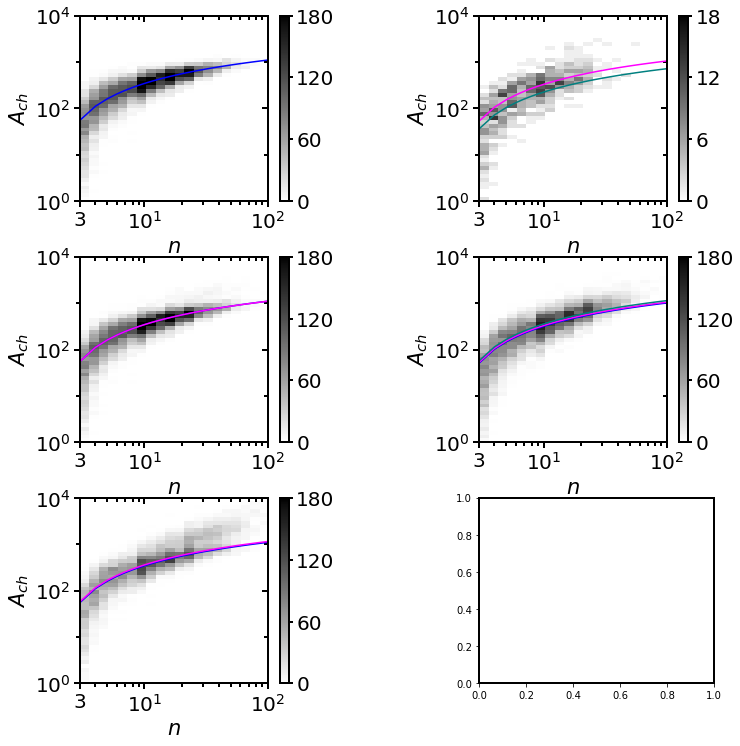

In [10]:
rcParams["axes.linewidth"] = 2
fig, ax = plt.subplots(3, 2, figsize=(11.36, 10.6))
fig.subplots_adjust(hspace=0.3, wspace=0.7, top=1)
axes = bh.axis.AxesTuple((
    bh.axis.Regular(20, 3, 103, transform=bh.axis.transform.log),
    bh.axis.Regular(50, 1, 15000, transform=bh.axis.transform.log)
))
histogram = bh.Histogram(*axes)
y_1 = [low_density_simulation, low_density_algorithm, high_density_algorithm, experimental_data, 
       varying_intensity_algorithm]
vmax = [180, 180, 180, 18, 180]
cbar_spacing = [60, 60, 60, 6, 60]
axeses = np.concatenate((ax[:, 0], ax[:, 1]))
empty_array = np.empty((98, ))
empty_array[:] = np.nan

y_2 = [convex_hull_true_curve, convex_hull_true_curve, convex_hull_true_curve, empty_array, 
       convex_hull_true_curve_varying]
y_3 = [empty_array, low_density_prediction, high_density_prediction, experimental_data_ch_prediction, 
       varying_intensity_prediction]
y_4 = [empty_array, empty_array, empty_array, experimental_data_nena_prediction, varying_intensity_prediction2]

for i, axis in enumerate(axeses):
    if i < len(axeses)-1:
        histogram.reset()
        histogram.fill(*y_1[i])
        mesh = axis.pcolormesh(*histogram.axes.edges.T, histogram.view().T, vmin=0, vmax=vmax[i], 
                               cmap=cc.m_gray.reversed(), zorder=0)
        cbar = fig.colorbar(mesh, ax=axis)
        cbar.ax.yaxis.set_major_locator(ticker.MultipleLocator(cbar_spacing[i]))
        cbar.ax.tick_params(width=2, length=4, labelsize=20)
        axis.plot(n, y_2[i], "-", color="blue")
        axis.plot(n, y_3[i], "-", color="magenta")
        axis.plot(n, y_4[i], "-", color="teal")
        axis.set_xscale("log")
        axis.set_yscale("log")
        axis.set_ylabel(r"$A_{ch}$", fontsize=21)
        axis.set_xlabel(r"$n$", fontsize=21)
        tick_spacing_x = 10
        axis.xaxis.set_major_locator(ticker.LogLocator(base=tick_spacing_x))
        tick_spacing_y = 100
        axis.yaxis.set_major_locator(ticker.LogLocator(base=tick_spacing_y))
        axis.tick_params(labelsize=20, width=2, length=6)
        axis.yaxis.set_minor_locator(ticker.LogLocator(numticks=10, subs=(1., 10.), base=10))
        axis.xaxis.set_minor_locator(ticker.LogLocator(numticks=10, subs=(2., 3., 4., 5., 6., 7., 8., 9.), base=10))
        axis.tick_params(which="minor", width=2, length=4, labelleft=False, left=True)
        second_axis_log(axis, "top", tick_spacing_x)
        second_axis_log(axis, "right", tick_spacing_y)
        axis.set_ylim(1, 1e4)
        xtick = axis.get_xticks()
        np.append(xtick, [3])
        xtick[-1] = 3
        labels = [item.get_text() for item in axis.get_xticklabels()]
        for i in range(len(xtick)):
            l = int(np.log10(xtick[i]))
            labels[i] = r"$10^{}$".format(l)
        labels[-1] = "3"
        axis.set_xticks(xtick)
        axis.set_xticklabels(labels)
        axis.set_xlim(3, 1e2)

fig.savefig(r"plt_figures\std_determination_2d_histograms.svg")

## The standard deviation determination via convex hull using clusters of n samples
Clusters of too low n (e.g. n = 3) might miss outlying points due to how DBSCAN works. 
Clusters of too high n have a higher probability of being a result of clusters merging, especially at high densities.

In [11]:
n_simulations = 30
parent_intensities = [1e-5, 2e-5, 3e-5, 4e-5, 5e-5, 10e-5, 15e-5, 20e-5]
limits_ = si.limits(parent_intensities, 15e-5, 5000)
cluster_std = 8
sim_param = dict(cluster_mu=9, seed=np.random.default_rng(100), min_samples=3)
alg_param = dict(eps=25, min_samples=3)
n = [3, 6, 12, 24, 36]
lookup_table_path = r"lookup_tables\lookup_table_area_2d.csv"

std_deter_n_means, std_deter_n_stds = stdd.std_determination_per_n(n_simulations, parent_intensities, limits_, 
                                                                   cluster_std, sim_param, alg_param, n, 
                                                                   lookup_table_path)
np.save(file=r"npy_files\std_determination_per_n_means.npy", arr=std_deter_n_means)
np.save(file=r"npy_files\std_determination_per_n_stds.npy", arr=std_deter_n_stds)


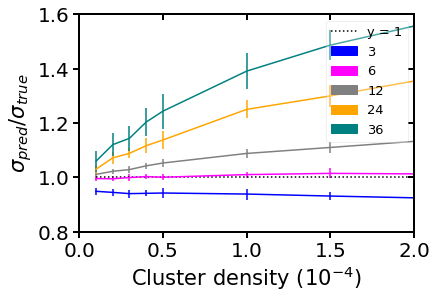

In [12]:
rcParams["axes.linewidth"] = 2
fig, ax = plt.subplots(figsize=(6, 4))
color = ["blue", "magenta", "grey", "orange", "teal"]
patches = {}
for i in range(len(n)):
    ax.errorbar(parent_intensities, std_deter_n_means[:, i], yerr=std_deter_n_stds[:, i], color=color[i])
    patches["patch{0}".format(i)] = mpatches.Patch(color=color[i], label=str(n[i]))
handles_legend = [mlines.Line2D([], [], label="y = 1", c="k", ls=":")]
for patch in patches.values():
    handles_legend.append(patch)
legend = ax.legend(handles=handles_legend, loc=1, fontsize=13, framealpha=0.3)
ax.plot(parent_intensities, np.full((len(parent_intensities),), 1),  color="k", ls=":")
ax.ticklabel_format(style="sci", axis="x", scilimits=(0,0))
ax.set_xlabel("Cluster density (" + r"$10^{-4}$" + ")", fontsize=21)
ax.set_ylabel(r"$\sigma_{pred}/\sigma_{true}$", fontsize=21)
ax.tick_params(labelsize=20, width=2, length=6)
ax.xaxis.get_offset_text().set_visible(False)
tick_spacing_x = 5e-5
ax.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing_x))
tick_spacing_y = 0.2
ax.yaxis.set_major_locator(ticker.MultipleLocator(tick_spacing_y))
ax.set_ylim(0.8, 1.6)
second_axis(ax, "top", tick_spacing_x)
second_axis(ax, "right", tick_spacing_y)
ax.set_xlim(0, 20e-5)
fig.savefig(r"plt_figures\std_determination_per_n.svg")

## The standard deviation determination via convex hull using different cluster counts

In [13]:
n_simulations = 200
cluster_std = 8
seed = np.random.default_rng(100)
sim_param = dict(parent_intensity=1e-5, lower_limit=-15000, upper_limit=15000, cluster_mu=9, 
                 seed=seed, min_samples=3)
alg_param = dict(eps=25, min_samples=3)
n = np.array([5, 6, 7, 8])
samplings = [1, 2, 5, 10, 20, 50, 100, 200, 500, 1000]
lookup_table_path = r"lookup_tables\lookup_table_area_2d.csv"

std_deter_cluster_count_means, std_deter_cluster_count_stds = \
    stdd.std_determination_per_cluster_count(n_simulations, cluster_std, sim_param, alg_param, samplings, n, seed,
                                             lookup_table_path)
np.save(file=r"npy_files\std_determination_per_cluster_counts_means.npy", arr=std_deter_cluster_count_means)
np.save(file=r"npy_files\std_determination_per_cluster_counts_stds.npy", arr=std_deter_cluster_count_stds)


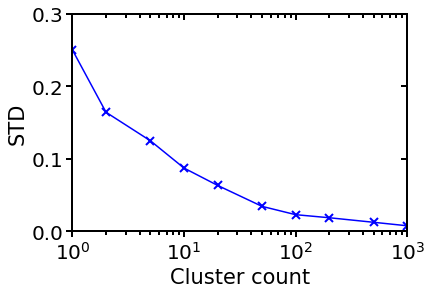

In [14]:
rcParams["axes.linewidth"] = 2
fig, ax = plt.subplots(figsize=(6, 4))
ax.plot(samplings, std_deter_cluster_count_stds, color="blue", marker="x", ms=8, mew=2)

ax.ticklabel_format(style="sci", axis="x", scilimits=(0,0))
ax.set_xlabel("Cluster count", fontsize=21)
ax.set_ylabel("STD", fontsize=21)
ax.tick_params(labelsize=20, width=2, length=6)
ax.set_xscale("log")
tick_spacing_x = 10
ax.xaxis.set_major_locator(ticker.LogLocator(base=tick_spacing_x))
tick_spacing_y = 0.1
ax.yaxis.set_major_locator(ticker.MultipleLocator(tick_spacing_y))
ax.xaxis.set_minor_locator(ticker.LogLocator(numticks=10, subs=(2., 3., 4., 5., 6., 7., 8., 9.), base=10))
ax.tick_params(which="minor", width=2, length=4)
second_axis_log(ax, "top", tick_spacing_x)
second_axis(ax, "right", tick_spacing_y)
ax.set_xlim(1, 1e3)
ax.set_ylim(0, 0.3)
fig.savefig(r"plt_figures\std_determination_per_cluster_count.svg")

## The robustness of low density data (with respect to localization precision) against $\epsilon$ of DBSCAN
If the density relative to localization precision is low, the clustering result will only change marginally with epsilons higher than the optimum epsilon. This can be exploited to e.g. find the localization precision.

In [15]:
n_simulations = 60
cluster_std = 8
parent_intensities = [1e-5]
limits_ = si.limits(parent_intensities, 15e-5, 3000)  
# the limits have to be relatively low since ARI can't handle high cluster counts
sim_param = dict(parent_intensity=1e-5, lower_limit=-limits_[0], upper_limit=limits_[0], cluster_mu=9, 
                 seed=np.random.default_rng(100), min_samples=3)
alg_param = dict(min_samples=3)
epsilons = np.arange(4, 50, 2)
lookup_table_path = r"lookup_tables\lookup_table_area_2d.csv"
std_score_mean, std_score_std, ari_mean, ari_std, correct_clust_mean, correct_clust_std = \
stdd.std_determination_per_epsilon(n_simulations, cluster_std, sim_param, alg_param, epsilons, lookup_table_path,
                                   minimum=5, maximum=8)
np.save(file=r"npy_files\std_determination_epsilon_std_score_mean.npy", arr=std_score_mean)
np.save(file=r"npy_files\std_determination_epsilon_std_score_std.npy", arr=std_score_std)
np.save(file=r"npy_files\std_determination_epsilon_ari_mean.npy", arr=ari_mean)
np.save(file=r"npy_files\std_determination_epsilon_ari_std.npy", arr=ari_std)
np.save(file=r"npy_files\std_determination_epsilon_correct_clust_mean.npy", arr=correct_clust_mean)
np.save(file=r"npy_files\std_determination_epsilon_correct_clust_std.npy", arr=correct_clust_std)

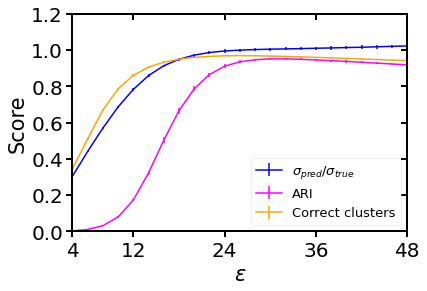

In [16]:
rcParams["axes.linewidth"] = 2
fig, ax = plt.subplots(figsize=(6, 4))
ax.errorbar(epsilons, std_score_mean, yerr=std_score_std, color="blue", label=r"$\sigma_{pred}/\sigma_{true}$")
ax.errorbar(epsilons, ari_mean, yerr=ari_std, color="magenta", label="ARI")
ax.errorbar(epsilons, correct_clust_mean, yerr=correct_clust_std, color="orange", label="Correct clusters")
ax.legend(loc=4, fontsize=13, framealpha=0.3)
ax.set_xlabel(r"$\epsilon$", fontsize=21)
ax.set_ylabel("Score", fontsize=21)
ax.tick_params(labelsize=20, width=2, length=6)
ax.xaxis.get_offset_text().set_visible(False)
tick_spacing_x = 12
ax.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing_x))
tick_spacing_y = 0.2
ax.yaxis.set_major_locator(ticker.MultipleLocator(tick_spacing_y))
ax.set_ylim(0, 1.2)
second_axis(ax, "top", tick_spacing_x)
second_axis(ax, "right", tick_spacing_y)
xtick = ax.get_xticks()
np.append(xtick, [])
xtick[-1] = 4
labels = [item.get_text() for item in ax.get_xticklabels()]
for i in range(len(xtick)):
    l = int(xtick[i])
    labels[i] = str(l)
ax.set_xticks(xtick)
ax.set_xticklabels(labels)
ax.set_xlim(4, 48)
fig.savefig(r"plt_figures\std_determination_per_epsilon.svg")